## Summary

The below code will examine performance -- win% and expected value -- by the count. For this analysis the count will be card values of 10 or more will be +1, card values of 6 or less will be +1 and all other will be 0.

NOTE: The results were unexpected. I would have thought as the count increases, the performance is better. However the output shows lower counts have better results... I ran this a few times, and this pattern repeated each time. Below the graphs, I ensured the Counter mechanisam is working as intended so am a little confused.

## Run Simulation

In [1]:
import pandas as pd
import numpy as np

from blackjack_simulator.components.chart import Chart
from blackjack_simulator.simulation.simulator import Simulator

import os
os.chdir(os.path.split(os.getcwd())[0])

In [2]:
chart = Chart.from_excel('data/strategy_charts.xlsx', sheet_name='Chart2')

In [13]:
chart.df

,2,3,4,5,6,7,8,9,10,A
4,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT
5,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT
6,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT
7,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT
8,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT
9,Action.HIT,Action.DOUBLE,Action.DOUBLE,Action.DOUBLE,Action.DOUBLE,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT
10,Action.DOUBLE,Action.DOUBLE,Action.DOUBLE,Action.DOUBLE,Action.DOUBLE,Action.DOUBLE,Action.DOUBLE,Action.DOUBLE,Action.HIT,Action.HIT
11,Action.DOUBLE,Action.DOUBLE,Action.DOUBLE,Action.DOUBLE,Action.DOUBLE,Action.DOUBLE,Action.DOUBLE,Action.DOUBLE,Action.DOUBLE,Action.HIT
12,Action.HIT,Action.HIT,Action.STAND,Action.STAND,Action.STAND,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT
13,Action.STAND,Action.STAND,Action.STAND,Action.STAND,Action.STAND,Action.HIT,Action.HIT,Action.HIT,Action.HIT,Action.HIT


In [3]:
simulator = Simulator(chart)

In [4]:
simulator.run(50000)

In [5]:
simulator.output_summary()

('Wins:32720, Pushes:6990, Losses:36107',
 'Buyin:82158, Payout:80978.5, Net:-1179.5',
 'Net_Units:-1179.5, Obs:75817.0, EV:-0.0156')

## Aggregate Records by Count

In [6]:
df = simulator.records_to_df()

In [7]:
df['win'] = np.where(df.result==1,1,0)
df['loss'] = np.where(df.result==-1,1,0)
df['push'] = np.where(df.result==0,1,0)

def cap_and_floor(value:int, threshold:int=8) -> int|str:
    if value >= threshold:
        return f'>+{threshold}'
    elif value <= -8:
        return f'<-{threshold}'
    else:
        return value

df['deck_count_cap'] = df.deck_count.apply(cap_and_floor)

In [8]:
grp_df = (
    df
    .groupby('deck_count_cap')
    .agg(
        wins=('win', 'sum'),
        losses=('loss', 'sum'),
        pushes=('push', 'sum'),
        buyin=('bet_units', 'sum'),
        payout=('final_payout', 'sum'),
    )
    .assign(obs=lambda x: x.wins+x.losses+x.pushes)
    .assign(win_pct=lambda x: round(x.wins/x.obs,2))
    .assign(profit=lambda x: x.payout - x.buyin)
    .assign(ev=lambda x: x.profit/x.obs)
    .reset_index()
)

# reorder the rows in the df so that <-8 is at the top
grp_df = pd.concat([grp_df.iloc[[15]], grp_df.drop(15)], ignore_index=True) 

In [9]:
grp_df

,deck_count_cap,wins,losses,pushes,buyin,payout,obs,win_pct,profit,ev
0,<-8,1,0,0,1,2.5,1,1.00,1.5,1.500000
1,-7,2,4,0,6,4.0,6,0.33,-2.0,-0.333333
2,-6,18,9,0,27,36.0,27,0.67,9.0,0.333333
3,-5,64,32,8,105,138.0,104,0.62,33.0,0.317308
4,-4,401,340,563,1308,1469.5,1304,0.31,161.5,0.123850
5,-3,1508,1593,225,3351,3482.5,3326,0.45,131.5,0.039537
6,-2,3612,3745,1063,8496,8785.5,8420,0.43,289.5,0.034382
7,-1,5118,5586,1370,12456,12190.0,12074,0.42,-266.0,-0.022031
8,0,6721,7792,1295,16713,15867.5,15808,0.43,-845.5,-0.053486
9,1,6278,6672,1208,15687,15695.0,14158,0.44,8.0,0.000565


## Plot Results

In [10]:
import matplotlib.pyplot as plt

def plot_metric(df, metric:str):
    if metric == 'ev':
        label = 'Expected Value'
    elif metric == 'win_pct':
        label = 'Win %'
    else:
        raise ValueError(f'metric {metric} doesnt exist')

    fig, ax1 = plt.subplots(figsize=(8, 5))

    ax1.scatter(df['deck_count_cap'].index, df[metric], color='blue', label=label)
    ax1.set_xlabel('Count')
    ax1.set_xticks(df['deck_count_cap'].index)
    ax1.set_xticklabels(df['deck_count_cap'])
    ax1.set_ylabel(label, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()

    ax2.bar(df['deck_count_cap'].index, df['obs'], alpha=0.5, color='orange', label='Observations')
    ax2.set_ylabel('obs', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Optional: Combined legend
    fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))

    plt.title(label)
    plt.tight_layout()
    plt.show()
    

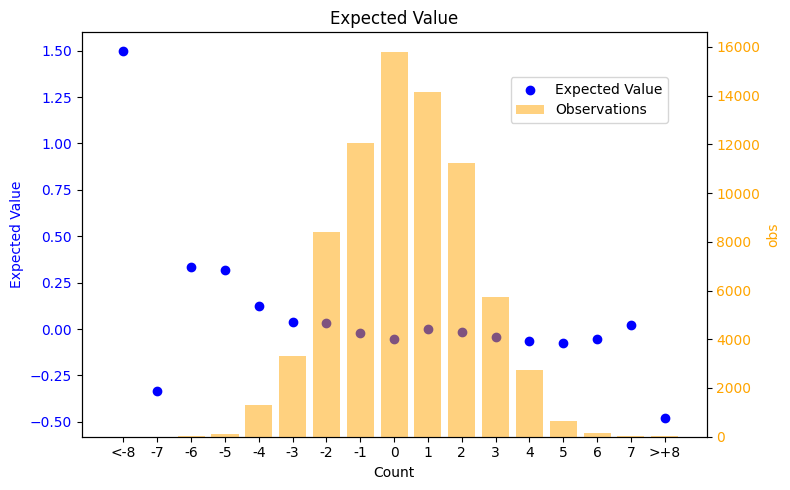

In [11]:
plot_metric(grp_df, 'ev')

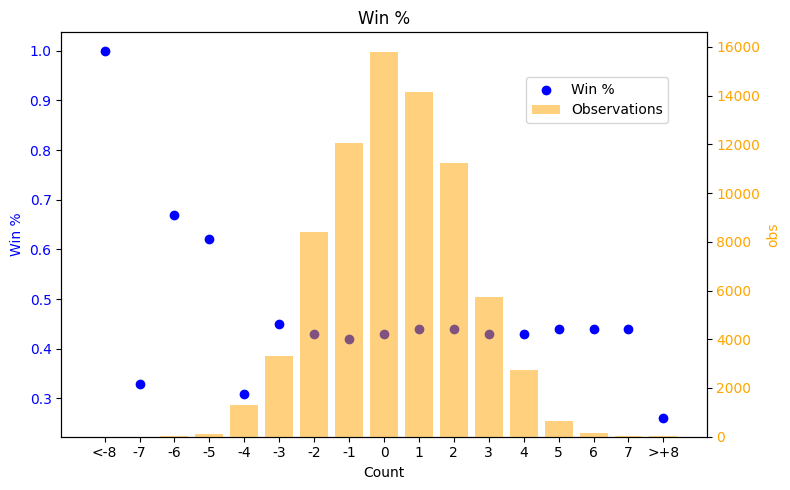

In [12]:
plot_metric(grp_df, 'win_pct')

## Check Count Mechanism 

In [16]:
from blackjack_simulator.components.deck import Deck

In [15]:
print(f'Low card values: {[c.value for c in simulator.counter.plus_list]}')
print(f'Med cards values: {[c.value for c in simulator.counter.neutral_list]}')
print(f'High cards values: {[c.value for c in simulator.counter.minus_list]}')

Low card values: [2, 3, 4, 5, 6]
Med cards values: [7, 8, 9]
High cards values: [10, 'J', 'Q', 'K', 'A']


In [17]:
deck = Deck.ndecks(3)
deck.shuffle()

In [18]:
for _ in range(3):
    deck.draw()

In [19]:
deck.drawn_cards

[Card(6, ♦), Card(2, ♥), Card(6, ♠)]

In [20]:
simulator.counter.get_count(deck)

3